In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from conformal_prediction import CP, calc_coverage
from preprocess_data import recode_variables_NHANES,recode_variables_LOOK_AHEAD, split_train_cal_test
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler

In [3]:
plots_folder = '/Users/carlharris/Documents/AIEM/Diabetes/waist_circumference/plots'
results_folder = '/Users/carlharris/Documents/AIEM/Diabetes/waist_circumference/results'

In [4]:
f_path = '/Users/carlharris/Documents/AIEM/Diabetes/waist_circumference/data.csv'
NHANES_df = pd.read_csv(f_path, na_values="None")
NHANES_df = recode_variables_NHANES(NHANES_df)

In [5]:
# df.drop(df[df['Female'] == 1].index, inplace=True)
NHANES_df.dropna(inplace=True)

ed_dummies = ['ED_LESS_HS', 'ED_HS_GED', 'ED_SOME_COLL_AA', 'ED_COLL_ABOVE', 'ED_OTHR_DK']
race_dummies = ['HISPANIC', 'WHITE', 'BLACK', 'OTHER_MIXED']

GENDER = 'FEMALE'
if GENDER == 'FEMALE':
    NHANES_df = NHANES_df[NHANES_df['FEMALE'] == 1]
else:
    NHANES_df = NHANES_df[NHANES_df['FEMALE'] == 0]
    
# X = NHANES_df[[ 'AGE', 'WEIGHT', 'HEIGHT', 'BMI'] + race_dummies + ed_dummies]
X = NHANES_df[[ 'AGE', 'WEIGHT', 'HEIGHT'] + race_dummies + ed_dummies]

outcome = 'WAIST'
y = NHANES_df[[outcome]]
y = y[outcome].astype(float)

In [ ]:
# scaler = StandardScaler()
# scaler.fit(X)
# X = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)

In [6]:
from sklearn.linear_model import LinearRegression

NHANES_X, NHANES_y = split_train_cal_test(X, y, trn_prop=0.5, cal_prop=0.25)

alpha = 0.05
reg = CP(NHANES_X['train'], NHANES_X['cal'], NHANES_y['train'], NHANES_y['cal'], alpha=alpha, regressor="QR")
reg.hyperparam_search(n_iter=100)
reg.train()

Hyperparameter optimization for QuantileRegressor model using random search over parameter set:
[{'alpha': array([0.        , 0.02915497, 0.06681005, 0.11544347, 0.17825594,
       0.25938137, 0.36415888, 0.49948425, 0.67426368, 0.9       ])}]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
  - best score: 0.5586369715889254
  - best params: {'alpha': 0.0}

Hyperparameter optimization for QuantileRegressor model using random search over parameter set:
[{'alpha': array([0.        , 0.02915497, 0.06681005, 0.11544347, 0.17825594,
       0.25938137, 0.36415888, 0.49948425, 0.67426368, 0.9       ])}]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
  - best score: 0.6705036222370508
  - best params: {'alpha': 0.0}

Hyperparameter optimization for QuantileRegressor model using random search over parameter set:
[{'alpha': array([0.        , 0.02915497, 0.06681005, 0.11544347, 0.17825594,
       0.25938137, 0.36415888, 0.49948425, 0.67426368, 0.9       ])}]
Fitting 5 

In [7]:
reg.calc_qhat()
cp_pred_df = reg.predict_cp_quantiles(NHANES_X['test'], NHANES_y['test'])

Calculating scores
At alpha=0.05, qhat = 0.012424503443426715
Conformalizing with qhat=0.012424503443426715


In [8]:
cov = calc_coverage(cp_pred_df)
print(cov)

0.954058508446642


In [9]:
from sklearn.metrics import r2_score
from sklearn.metrics import d2_pinball_score

r2 = r2_score(cp_pred_df['y_true'], cp_pred_df['lower'])
print(f"R2: {r2}")

r2 = r2_score(cp_pred_df['y_true'], cp_pred_df['upper'])
print(f"R2: {r2}")

r2 = r2_score(cp_pred_df['y_true'], cp_pred_df['median'])
print(f"R2: {r2}")

R2: 0.44274394712955445
R2: 0.4568736144576978
R2: 0.886328743849936


Predicted CIs (sorted by y_true)

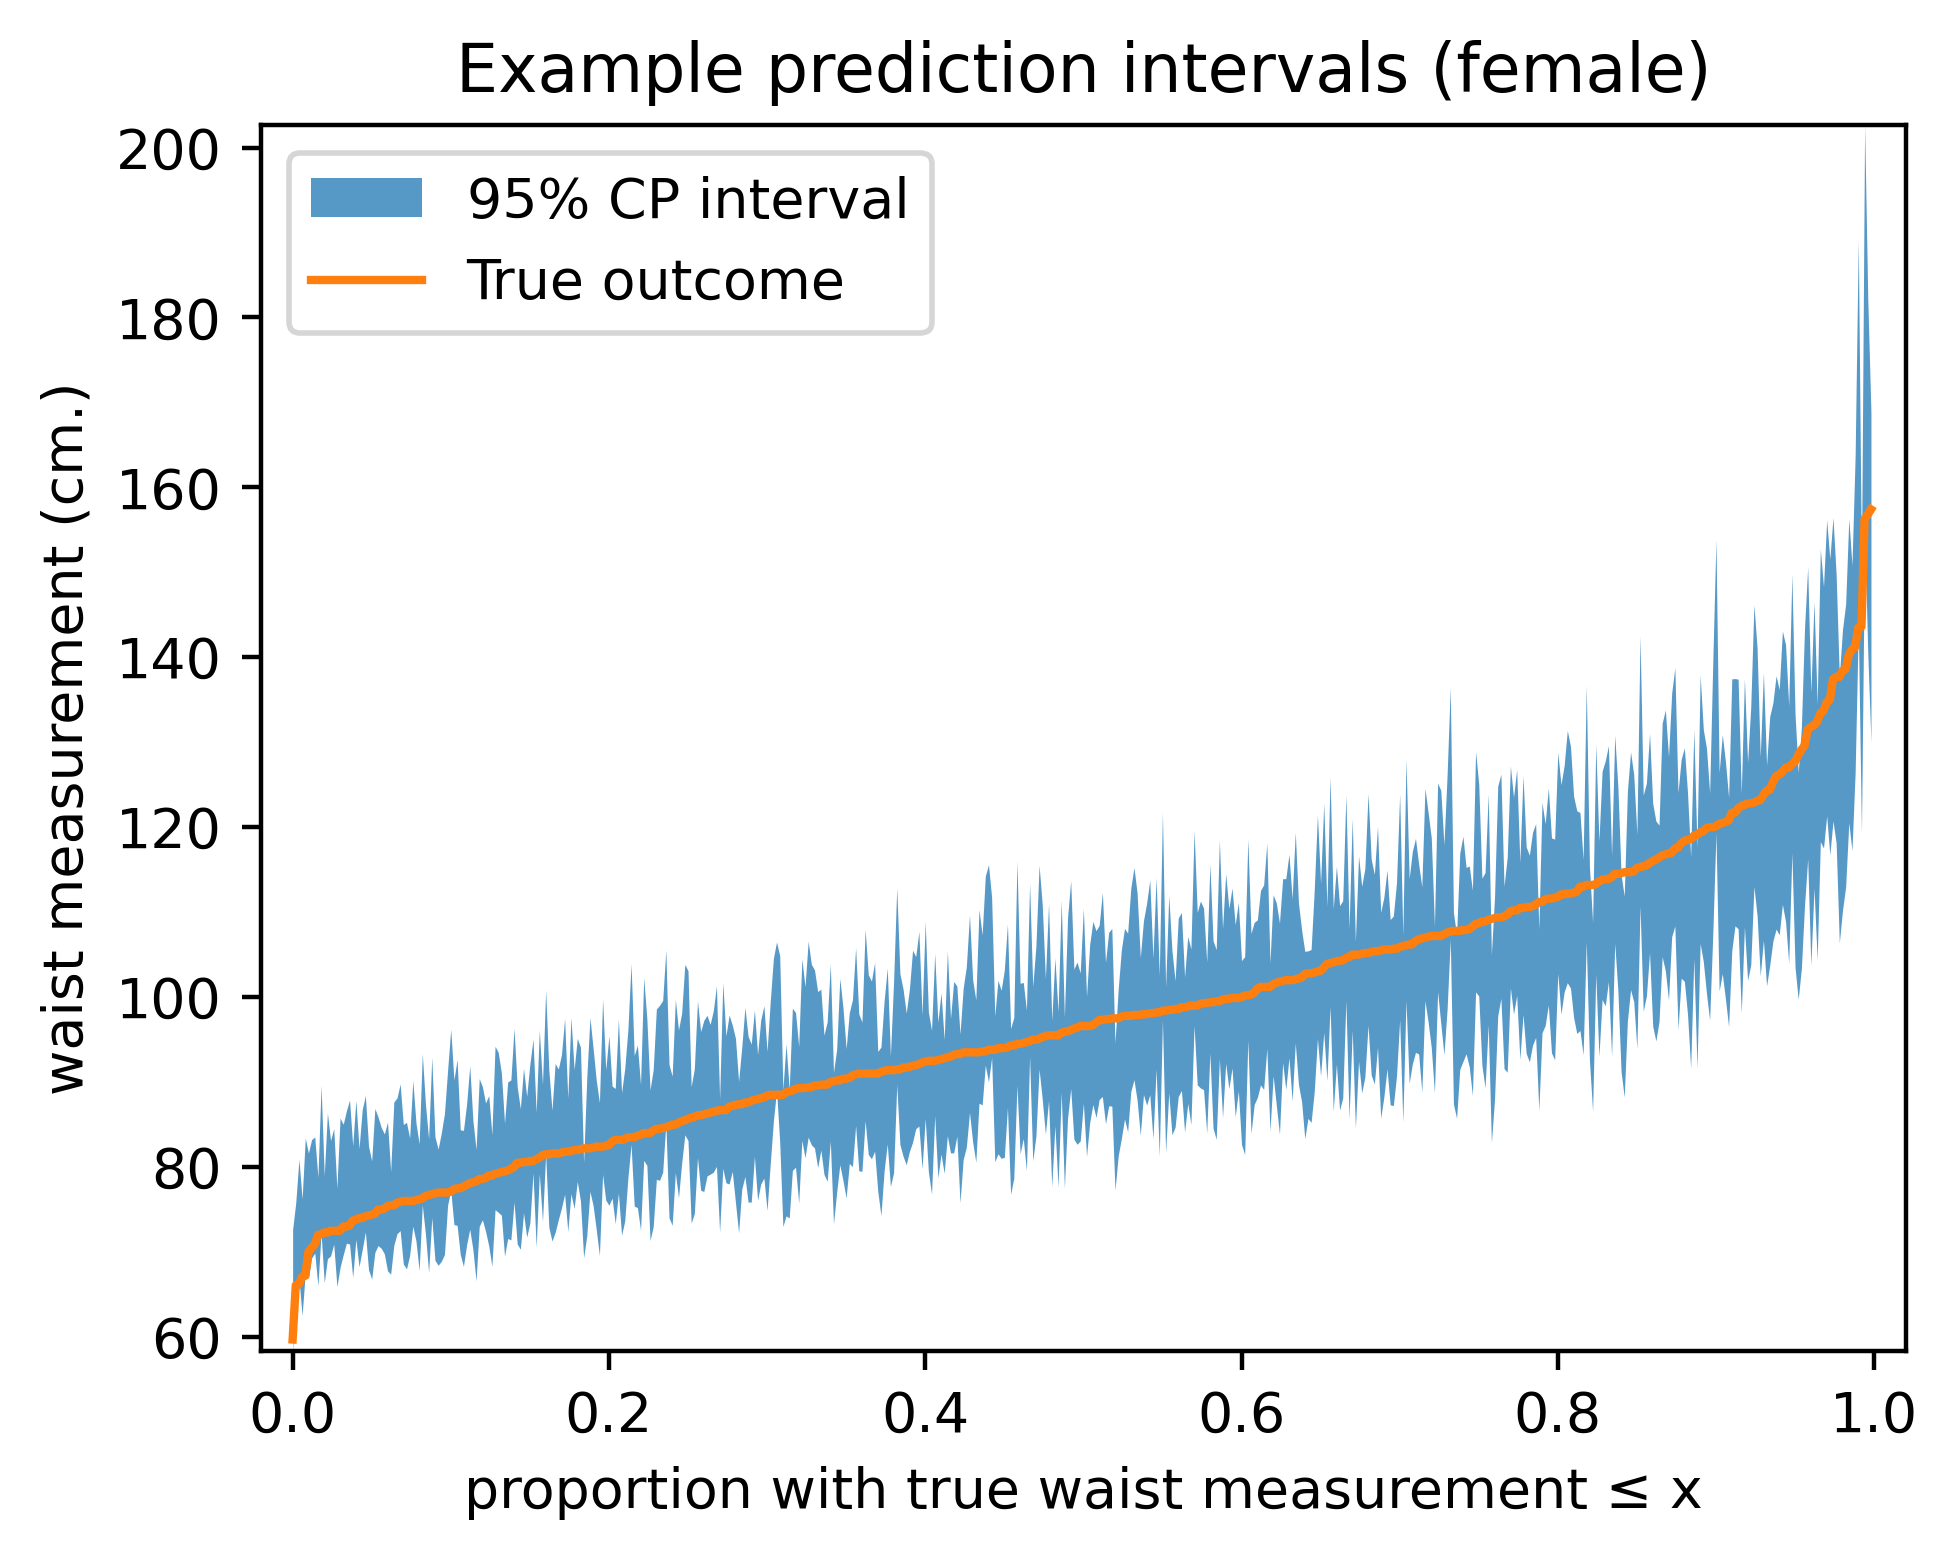

In [10]:
sample_df = cp_pred_df.copy()
n_sample = 500

sample_df = sample_df.sample(n = n_sample)
sample_df = sample_df.sort_values(by=['y_true'])
sample_df = sample_df.reset_index()

plt.figure(figsize=(5, 4), dpi=400)

lbl = "{:.0f}% CP interval".format((1-alpha) * 100)
plt.fill_between(sample_df.index/n_sample, sample_df['lower'], sample_df['upper'], alpha=0.75, color='C0', label=lbl, linewidth=0, zorder=1)
plt.plot(sample_df.index/n_sample, sample_df['y_true'], linewidth=1.5, color='C1', label="True outcome", zorder=2)
# plt.scatter(sample_df.index/n_sample, sample_df['median'], s=1, color='C3', label="Predicted outcome", alpha=0.75, zorder=3)

if GENDER is not None:
    # Img path with gender
    img_path = os.path.join(plots_folder, "NH_ex_preds_{:.0f}Q_{gender}.pdf".format((1-alpha) * 100, gender=GENDER))
    if GENDER == "MALE":
        plt.title("Example prediction intervals (male)")
    else:
        plt.title("Example prediction intervals (female)")

else:
    img_path = os.path.join(plots_folder, "NH_ex_preds_{:.0f}Q.pdf".format((1-alpha) * 100))
    plt.title("Example prediction intervals")

plt.legend(loc='upper left')
plt.ylabel(f"waist measurement (cm.)")
plt.xlabel(f"proportion with true waist measurement ≤ x")
plt.xlim([-0.02, 1.02])
plt.ylim([np.min(sample_df['lower']), np.max(sample_df['upper'])])
plt.tight_layout()


plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()

Coverage by difference size

In [ ]:
test_cp_df_tmp = cp_pred_df.copy()
test_cp_df_tmp = test_cp_df_tmp.sort_values(by=["diff"])
test_cp_df_tmp = test_cp_df_tmp.reset_index()
dfs = np.array_split(test_cp_df_tmp, 5)

plt.figure(figsize=(6, 4), dpi=400)
x_labels = []
coverages = []
for i, split_df in enumerate(dfs):
    min_max = (split_df['diff'].iloc[0], split_df['diff'].iloc[-1])
    coverage = calc_coverage(split_df)
    print(f"Range {min_max[0]} to {min_max[1]}: {coverage}")
    coverages.append(coverage)
    
    x_labels.append("{:.1f}-{:.1f}".format(min_max[0], min_max[1]))

plt.bar(np.arange(len(coverages)), coverages)
if np.max(coverages)+0.05 < 1:
    bar_max = np.max(coverages)+0.05
else:
    bar_max = 1
plt.ylim(np.min(coverages)-0.05, bar_max)
plt.axhline(y=1-alpha, color='r', linestyle='--', label="1-α coverage")
plt.xticks(np.arange(len(coverages)), x_labels, rotation=-20)

plt.title("Size-stratified coverage (interval size vs. coverage)")
plt.ylabel('Empirical coverage')
plt.legend(loc='upper left')
plt.xlabel("Interval width (cm.)")
plt.tight_layout()
img_path = os.path.join(plots_folder, "SSC_{:.0f}Q.pdf".format((1-alpha) * 100))
plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()

Coverage by true WC

Range 59.7 to 82.5: 0.9289392378990731 (avg diff = 16.201787228790337)
Range 82.5 to 91.6: 0.976313079299691 (avg diff = 18.89559109925232)
Range 91.6 to 100.0: 0.972193614830072 (avg diff = 21.27737631407124)
Range 100.0 to 111.5: 0.9474768280123584 (avg diff = 23.929204553655758)
Range 111.5 to 187.5: 0.945360824742268 (avg diff = 29.64325517930316)


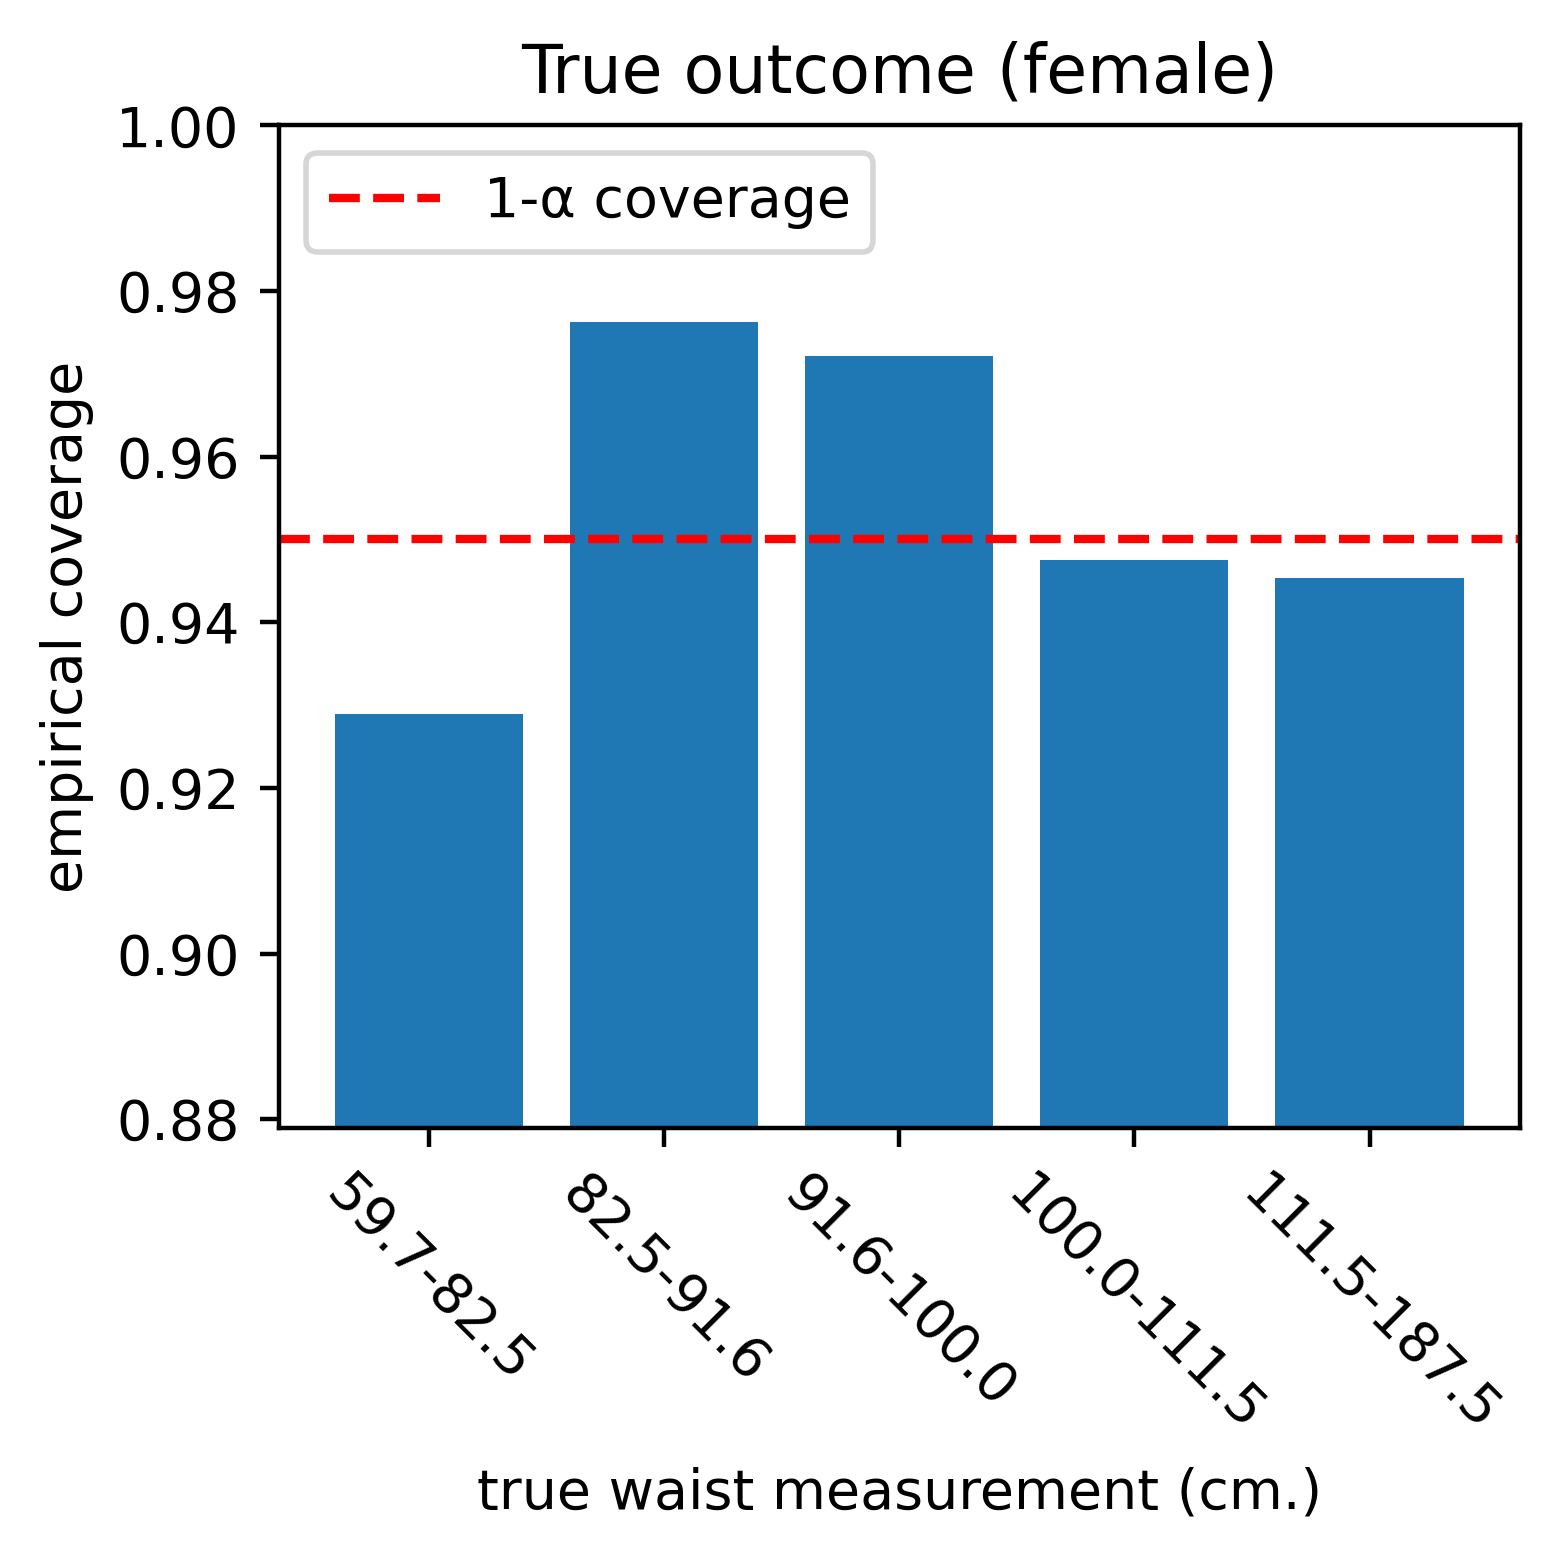

In [11]:
test_cp_df_tmp = cp_pred_df.copy()
test_cp_df_tmp = test_cp_df_tmp.sort_values(by=["y_true"])
test_cp_df_tmp = test_cp_df_tmp.reset_index()
dfs = np.array_split(test_cp_df_tmp, 5)

plt.figure(figsize=(4, 4), dpi=400)
x_labels = []
coverages = []
for split_df in dfs:
    min_max = (split_df['y_true'].iloc[0], split_df['y_true'].iloc[-1])
    coverage = calc_coverage(split_df)
    print(f"Range {min_max[0]} to {min_max[1]}: {coverage} (avg diff = {np.mean(split_df['diff'])})")
    coverages.append(coverage)
    
    x_labels.append("{:.1f}-{:.1f}".format(min_max[0], min_max[1]))
    
plt.bar(np.arange(len(coverages)), coverages)
if np.max(coverages)+0.05 < 1:
    bar_max = np.max(coverages)+0.05
else:
    bar_max = 1
plt.ylim(np.min(coverages)-0.05, bar_max)
plt.axhline(y=1-alpha, color='r', linestyle='--', label="1-α coverage")
plt.xticks(np.arange(len(coverages)), x_labels, rotation=-45)

if GENDER is not None:
    # Img path with gender
    img_path = os.path.join(plots_folder, "NH_OCC_{:.0f}Q_{gender}.pdf".format((1-alpha) * 100, gender=GENDER))
    if GENDER == "MALE":
        plt.title("True outcome (male)")
    else:
        plt.title("True outcome (female)")
else:
    img_path = os.path.join(plots_folder, "NH_OCC_{:.0f}Q.pdf".format((1-alpha) * 100))
    plt.title("True outcome")
    
plt.ylabel('empirical coverage')
plt.legend(loc='upper left')
plt.xlabel("true waist measurement (cm.)")
plt.tight_layout()
plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()

Marginal coverage + coverage by gender

In [ ]:
plt.figure(figsize=(3, 4), dpi=400)
x_labels = []
coverages = []

coverages.append(calc_coverage(cp_pred_df))
x_labels.append("all")

X_test = NHANES_X['test']
y_col = cp_pred_df[X_test['FEMALE'] == 0]   
coverages.append(calc_coverage(y_col))
x_labels.append("male")

y_col = cp_pred_df[X_test['FEMALE'] == 1]   
coverages.append(calc_coverage(y_col))
x_labels.append("female")

# Specify color for the bars
colors = ['C1'] + ['C0'] * (len(coverages)-1)  # Set the first bar to 'C0' and the rest to 'C1'

plt.bar(np.arange(len(coverages)), coverages, color=colors)

if np.max(coverages)+0.05 < 1:
    bar_max = np.max(coverages)+0.05
else:
    bar_max = 1
plt.ylim(np.min(coverages)-0.05, bar_max)
plt.axhline(y=1-alpha, color='r', linestyle='--', label="1-α coverage")
plt.xticks(np.arange(len(coverages)), x_labels, rotation=-45)
plt.title("Gender")
plt.ylabel('empirical coverage')
plt.legend(loc='upper left')
plt.tight_layout()
img_path = os.path.join(plots_folder, "NH_FSC_gender_{:.0f}Q.pdf".format((1-alpha) * 100))
plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()

Coverage by ethnicity

HISPANIC: 0.9495341614906833
WHITE: 0.9586820083682008
BLACK: 0.9489177489177489
OTHER_MIXED: 0.9599198396793587


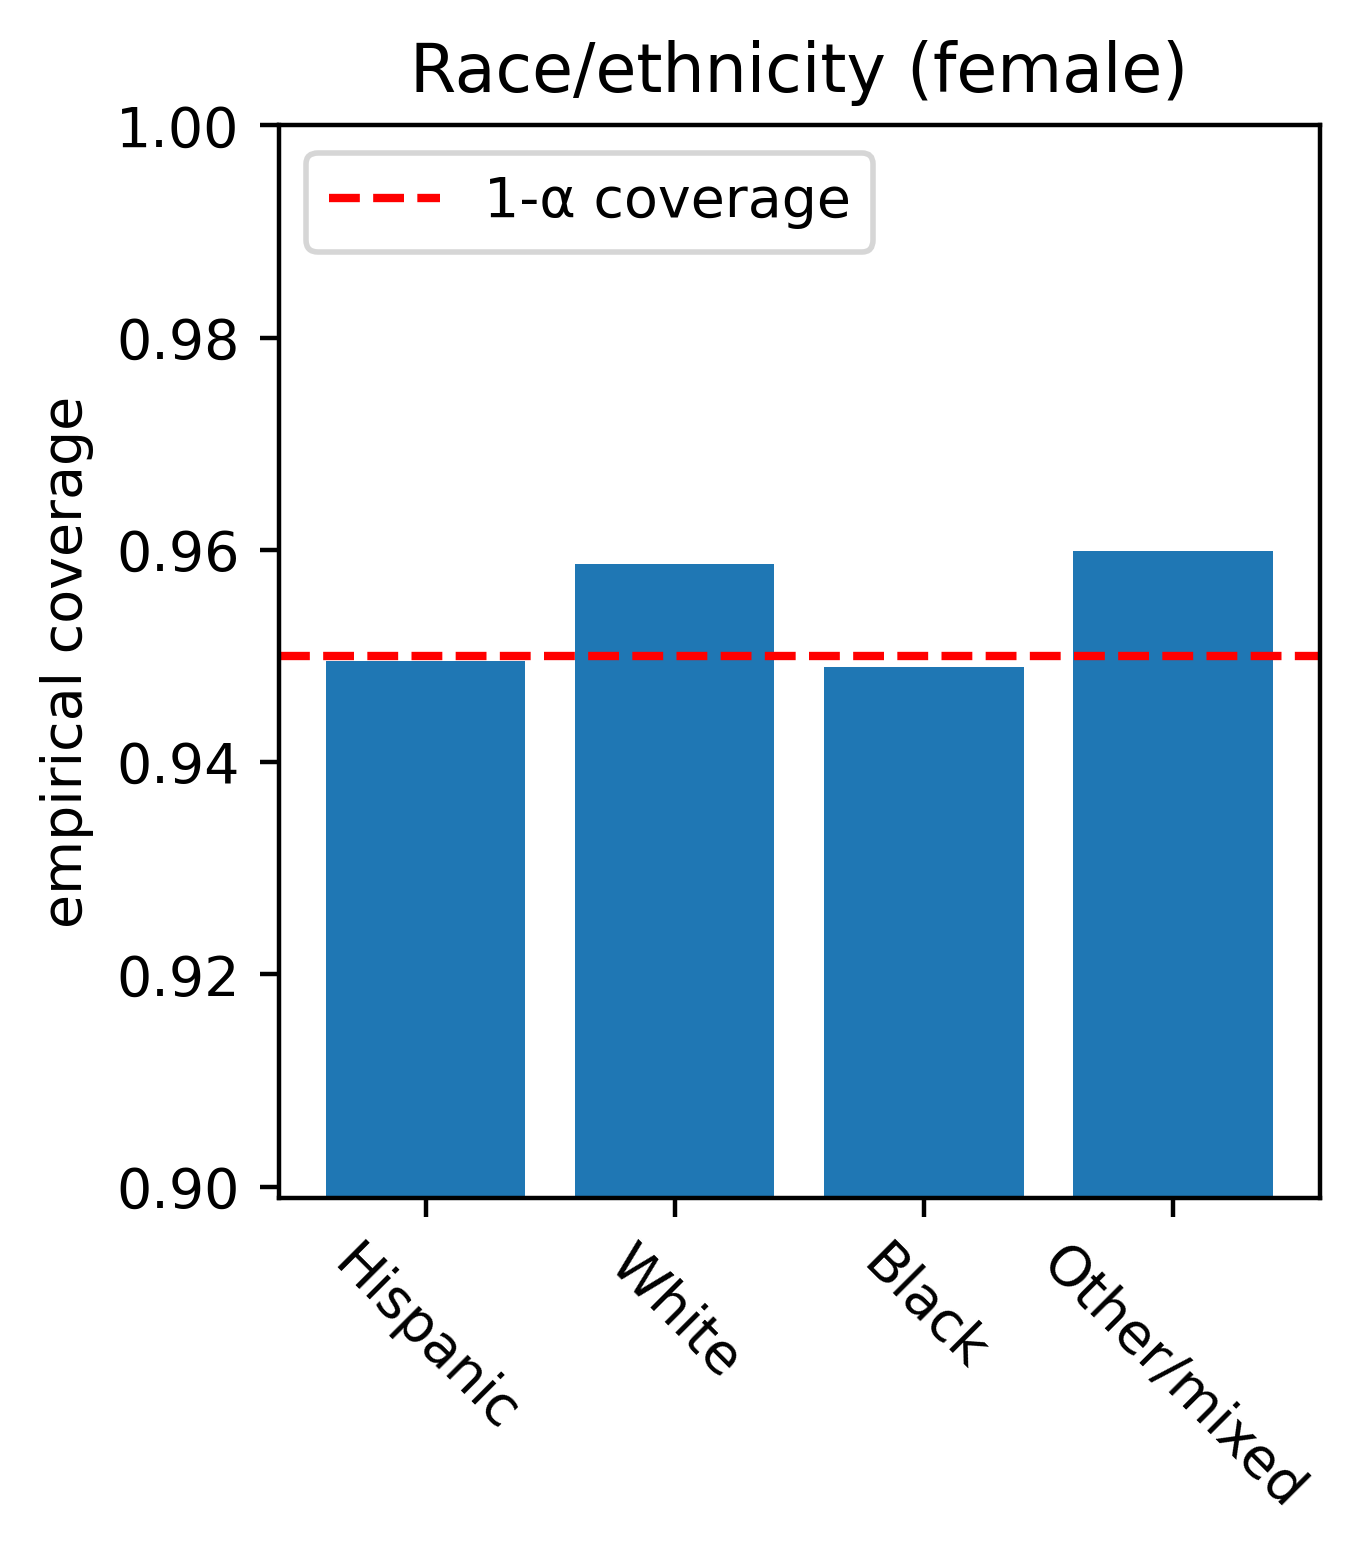

In [12]:
plt.figure(figsize=(3.5, 4), dpi=400)
x_labels = []
coverages = []

X_test = NHANES_X['test']

eth_mappings = {
    "HISPANIC": "Hispanic",
    "WHITE": "White",
    "BLACK": "Black",
    "OTHER_MIXED": "Other/mixed"
}

for col in race_dummies:
    y_col = cp_pred_df[X_test[col] == 1]
    coverage = calc_coverage(y_col)
    print(f"{col}: {coverage}")
    coverages.append(coverage)
    x_labels.append(eth_mappings[col])

plt.bar(np.arange(len(coverages)), coverages)
if np.max(coverages)+0.05 < 1:
    bar_max = np.max(coverages)+0.05
else:
    bar_max = 1
plt.ylim(np.min(coverages)-0.05, bar_max)
plt.axhline(y=1-alpha, color='r', linestyle='--', label="1-α coverage")
plt.xticks(np.arange(len(coverages)), x_labels, rotation=-45)

if GENDER is not None:
    # Img path with gender
    img_path = os.path.join(plots_folder, "NH_FSC_ethnicity_{:.0f}Q_{gender}.pdf".format((1-alpha) * 100, gender=GENDER))
    if GENDER == "MALE":
        plt.title("Race/ethnicity (male)")
    else:
        plt.title("Race/ethnicity (female)")
else:
    img_path = os.path.join(plots_folder, "NH_FSC_ethnicity_{:.0f}Q.pdf".format((1-alpha) * 100))
    plt.title("Race/ethnicity")
    

plt.ylabel('empirical coverage')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()

Coverage by education

ED_LESS_HS: 0.9512195121951219
ED_HS_GED: 0.9487895716945997
ED_SOME_COLL_AA: 0.9627694317439582
ED_COLL_ABOVE: 0.9499121265377856
ED_OTHR_DK: 1.0


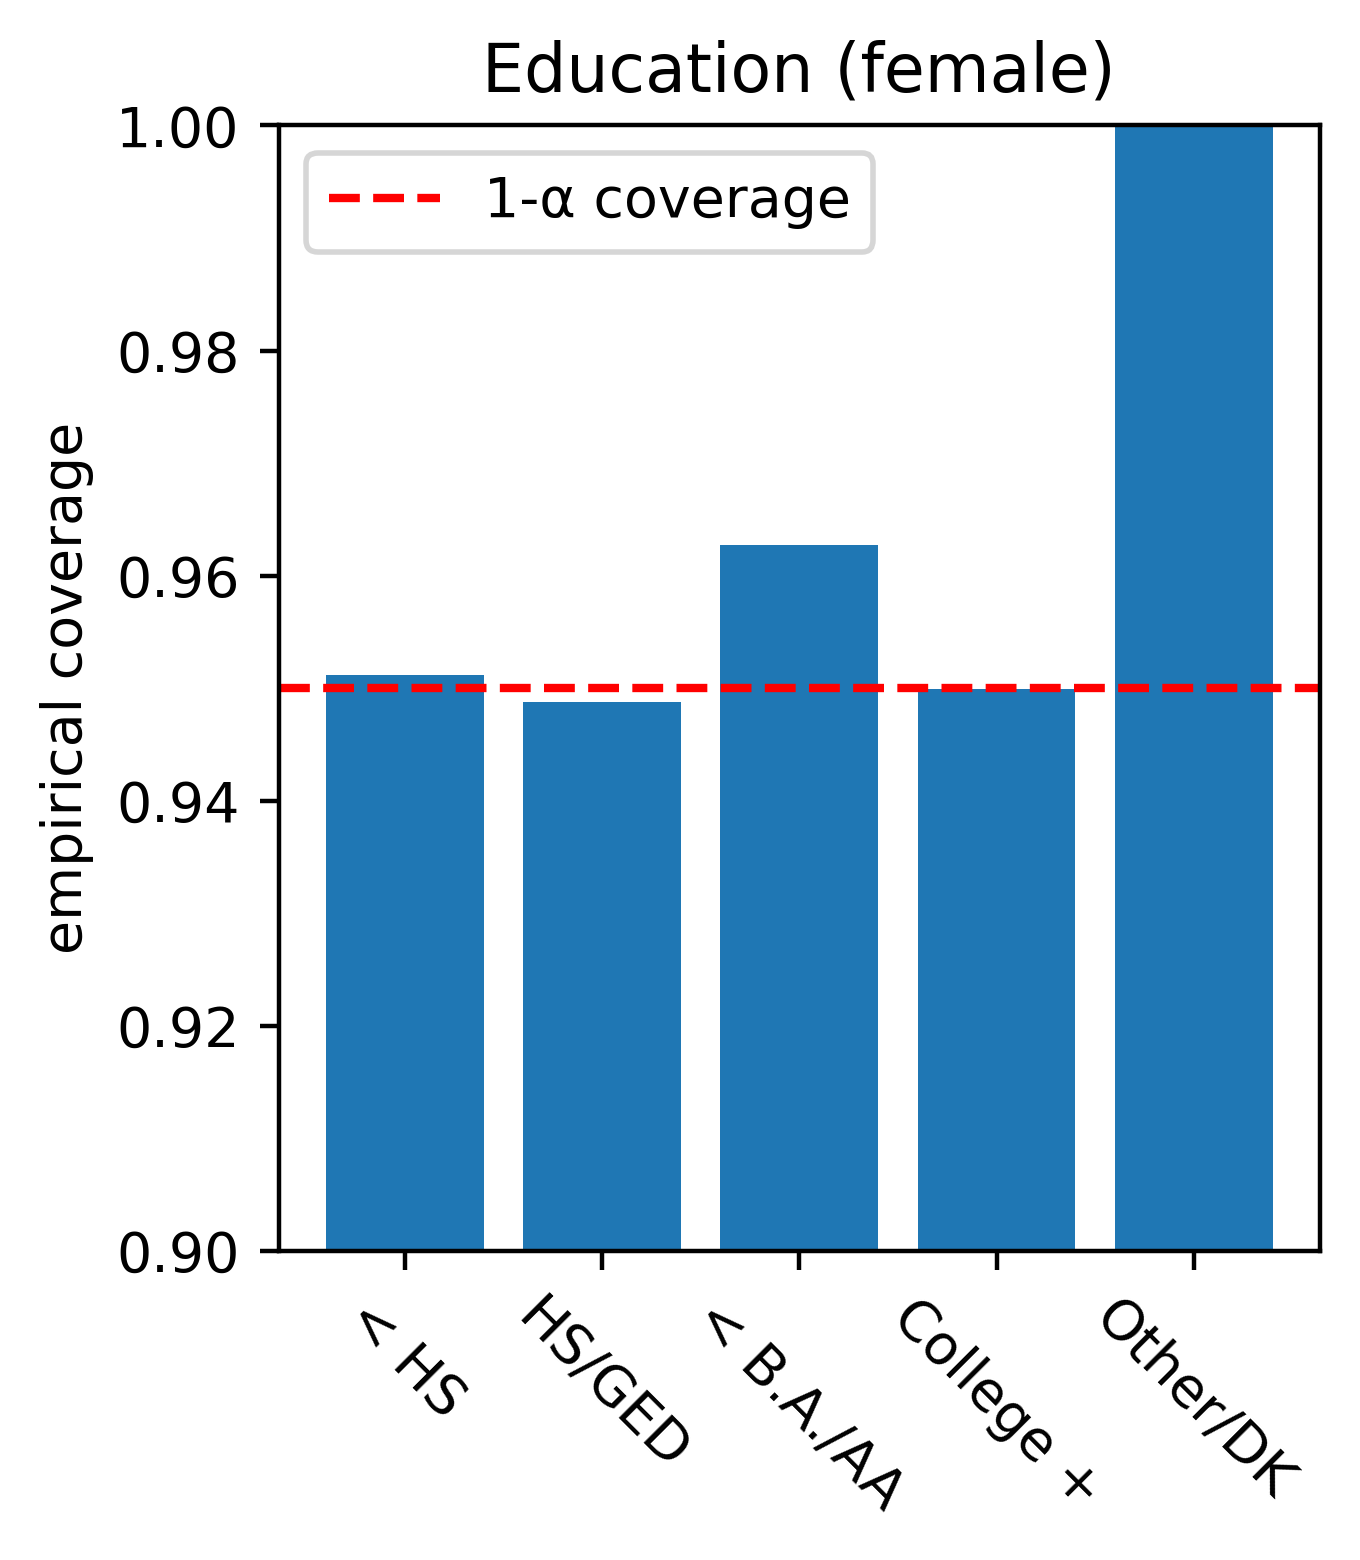

In [13]:
plt.figure(figsize=(3.5, 4), dpi=400)

x_labels = []
coverages = []

label_mappings = {
    'ED_LESS_HS': '< HS',
    'ED_HS_GED': 'HS/GED',
    'ED_SOME_COLL_AA': '< B.A./AA',
    'ED_COLL_ABOVE': 'College +',
    'ED_OTHR_DK': 'Other/DK'
}

for col in ed_dummies:
    y_col = cp_pred_df[X_test[col] == 1]
    coverage = calc_coverage(y_col)
    print(f"{col}: {coverage}")
    coverages.append(coverage)
    x_labels.append(label_mappings[col])

plt.bar(np.arange(len(coverages)), coverages)
if np.max(coverages)+0.05 < 1:
    bar_max = np.max(coverages)+0.05
else:
    bar_max = 1
plt.ylim(1-2*alpha, bar_max)
plt.axhline(y=1-alpha, color='r', linestyle='--', label="1-α coverage")
plt.xticks(np.arange(len(coverages)), x_labels, rotation=-45)
# plt.gca().set_xticklabels(x_labels, rotation=-30, verticalalignment='bottom', position=(0,-0.15))

if GENDER is not None:
    # Img path with gender
    img_path = os.path.join(plots_folder, "NH_FSC_ed_{:.0f}Q_{gender}.pdf".format((1-alpha) * 100, gender=GENDER))
    if GENDER == "MALE":
        plt.title("Education (male)")
    else:
        plt.title("Education (female)")
else:
    img_path = os.path.join(plots_folder, "NH_FSC_ed_{:.0f}Q.pdf".format((1-alpha) * 100))
    plt.title("Education")
plt.ylabel('empirical coverage')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()

Prediction interval size

In [ ]:
lr = LinearRegression().fit(NHANES_X['train'], NHANES_y['train'])
y_hat = lr.predict(NHANES_X['test'])
from sklearn.metrics import r2_score
r2 = r2_score(NHANES_y['test'], y_hat)
print(f"R2: {r2}")

Interval size over alpha

In [ ]:
n_inner_loops = 3
alphas = [0.2, 0.1, 0.05, 0.01]
cp_dfs = []
for alpha in  alphas:
    cp_pred_df = pd.DataFrame()
    reg.alpha = alpha
    reg.calc_qhat()
    tmp_cp_pred_df = reg.predict_cp_quantiles(NHANES_X['test'], NHANES_y['test'])
    cp_pred_df = pd.concat([cp_pred_df, tmp_cp_pred_df], axis=0)
    cp_dfs.append(cp_pred_df)


In [ ]:
import matplotlib.pyplot as plt
# plt.rcParams['text.usetex'] = True
plt.figure(figsize=(5, 4), dpi=400)
colors = ['C0', 'C1', 'C2', 'C3']

mins = []
maxs = []
for i, cp_df in enumerate(cp_dfs):
    plt.hist(cp_df['diff'], bins=25, color=colors[i], alpha=0.7-0.1*i, label="α={:.2f}".format(alphas[i]), density=True)
    plt.axvline(x=np.mean(cp_df['diff']), color=colors[i], linewidth=2)
    mins.append(cp_df['diff'].min())
    maxs.append(cp_df['diff'].max())
plt.ylim([0, 0.2])
plt.xlim([np.min(mins), np.max(maxs)])
plt.ylabel('density of observations')
plt.xlabel("interval width (cm.)")  # Modified underlining with mathtext mode
plt.title("Specified α vs. interval size")

if GENDER is not None:
    # Img path with gender
    img_path = os.path.join(plots_folder, "NH_alpha_vs_pred_size_{gender}.pdf".format(gender=GENDER))
    if GENDER == "MALE":
        plt.title("Specified α vs. interval size (male)")
    else:
        plt.title("Specified α vs. interval size (female)")
else:
    img_path = os.path.join(plots_folder, "NH_alpha_vs_pred_size.pdf")
    plt.title("Specified α vs. interval size")

plt.legend()
plt.tight_layout()
plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()
